## Real-time Recognition for American Sign language using Deep learning and Open CV
The project was inspired by a youtube channel named Exter Minar with the video used as a tutorial guide from a link below 
https://www.youtube.com/watch?v=6Bn0PY_ouBY&t=221s

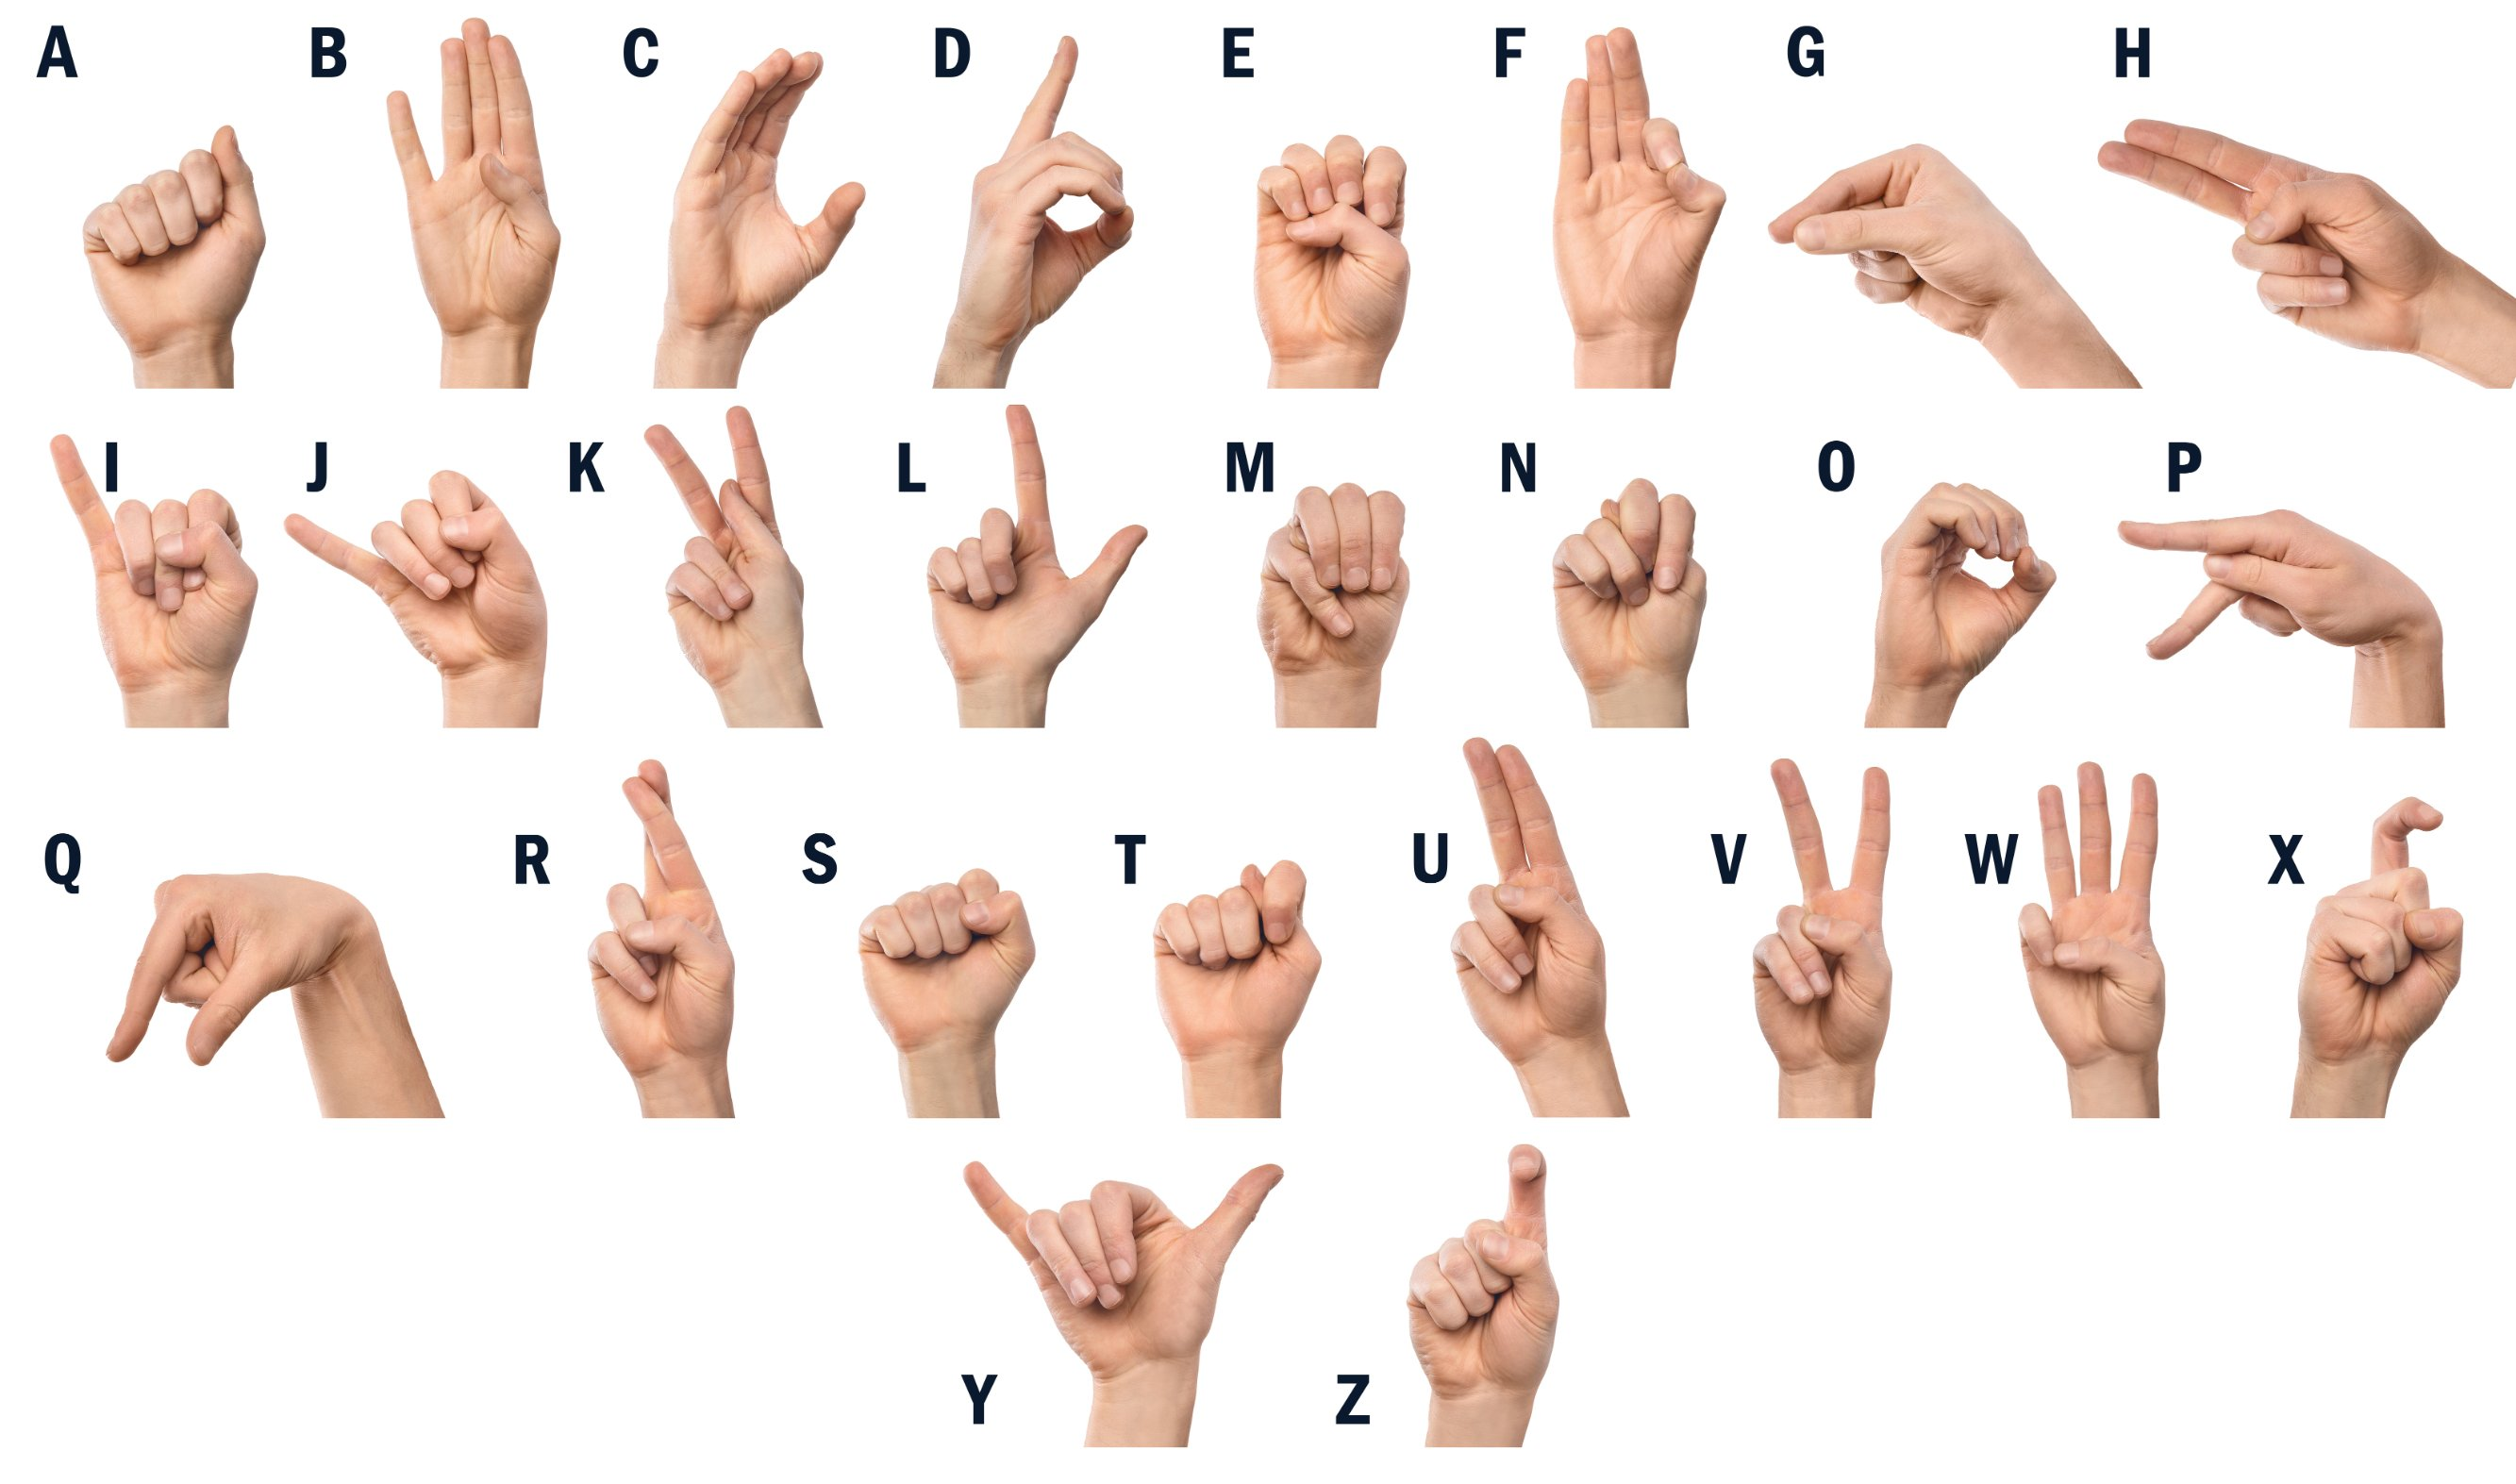

# Import relevant libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Import datasets**

In [3]:
# Load your CSV file containing image paths and labels
df_train = pd.read_csv(r"C:\Users\bida20-083\Downloads\sign_mnist_train\sign_mnist_train.csv")
df_test = pd.read_csv(r"C:\Users\bida20-083\Downloads\sign_mnist_test\sign_mnist_test.csv")

# **DATA CARD**
# About Dataset
## Source: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications. As noted in one recent replacement called the Fashion-MNIST dataset, the Zalando researchers quoted the startling claim that "Most pairs of MNIST digits (784 total pixels per sample) can be distinguished pretty well by just one pixel". To stimulate the community to develop more drop-in replacements, the Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and finally 3 degrees rotation. Because of the tiny size of the images, these modifications effectively alter the resolution and class separation in interesting, controllable ways.

# **Exploratory Data Analysis**

In [4]:
# Print the first 5 rows of the dataset
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Inspect dataset for missing values

In [5]:
df_train.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [7]:
# Extract labels from the sign_mnist_train dataset
labels = df_train['label'].values

In [8]:
#Identifying lables shape
labels.shape

(27455,)

<Axes: ylabel='count'>

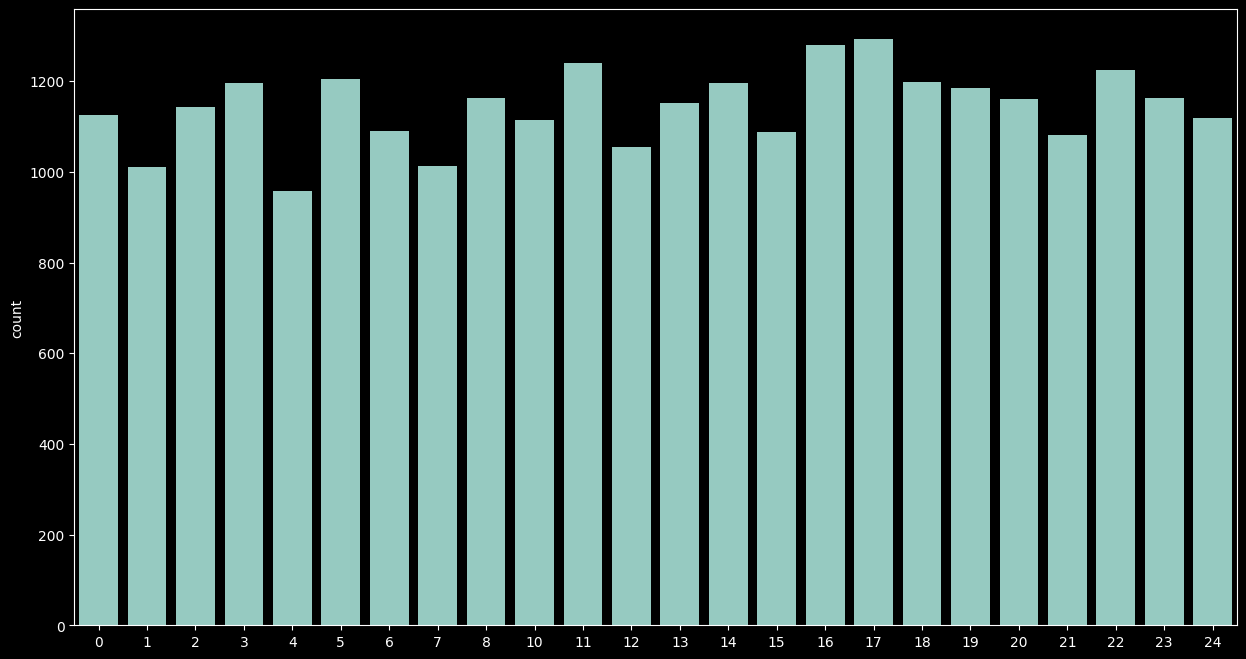

In [9]:
import seaborn as sbn
plt.figure(figsize=(15,8))
sbn.countplot(x = labels)

In [10]:
# Inspecting columns of the dataset for columns to be dropped 
print(df_train.columns)

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)


In [11]:
# Since all images are in a row of 785 values,
# label column has to be dropped and reshape 784 pixel columns to 28 x 28 shape
pixels = df_train.drop('label', axis = 1, inplace = True)
pixels = df_train.values
pixels = np.array([np.reshape(i,(28,28)) for i in pixels])
pixels = np.array([i.flatten() for i in pixels])

In [12]:
# Since we have more than 2 labels, hot 1 encoding is implemented
from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(labels)

# **Build the model**
Building the neural network requires configuring the layers of the model, then compiling the model.

Set up the layers
The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

In [13]:
#Define the CNN model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

model = models.Sequential()
model.add(layers.Conv2D(28, (3, 3), activation='relu', input_shape = (28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(28, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(28, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(24, activation='softmax'))

In [14]:
x_train, x_test, y_train, y_test = train_test_split(pixels, labels, test_size = 0.3, random_state = 101)

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [15]:
# Normalising
x_train = x_train/225
x_test = x_test/225

 **Compile the mode**

In [16]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
#'adam'

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 28)        7084      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 28)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 28)          7084      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 28)         0

In [17]:
# Convert pixel values to NumPy arrays
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

# Reshape the data to 28x28 images (assuming each row represents an image)
x_test = x_test.reshape(x_test.shape[0],28,28,1)

# **Preprocess the data**
The data must be preprocessed before training the network. If you inspect the any image in the training set, you will see that the pixel values fall in the range of 0 to 28:

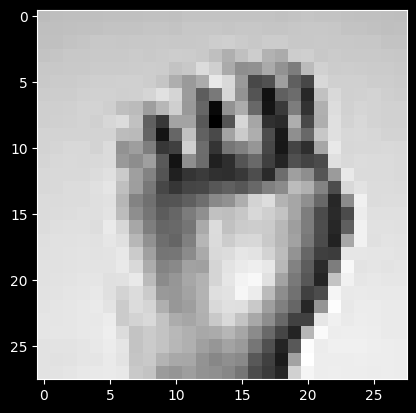

In [18]:
plt.imshow(x_train[20],cmap='gray')
plt.show()

In [20]:
class_names = ['A','B','C','D','E','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 5 images from the training set.

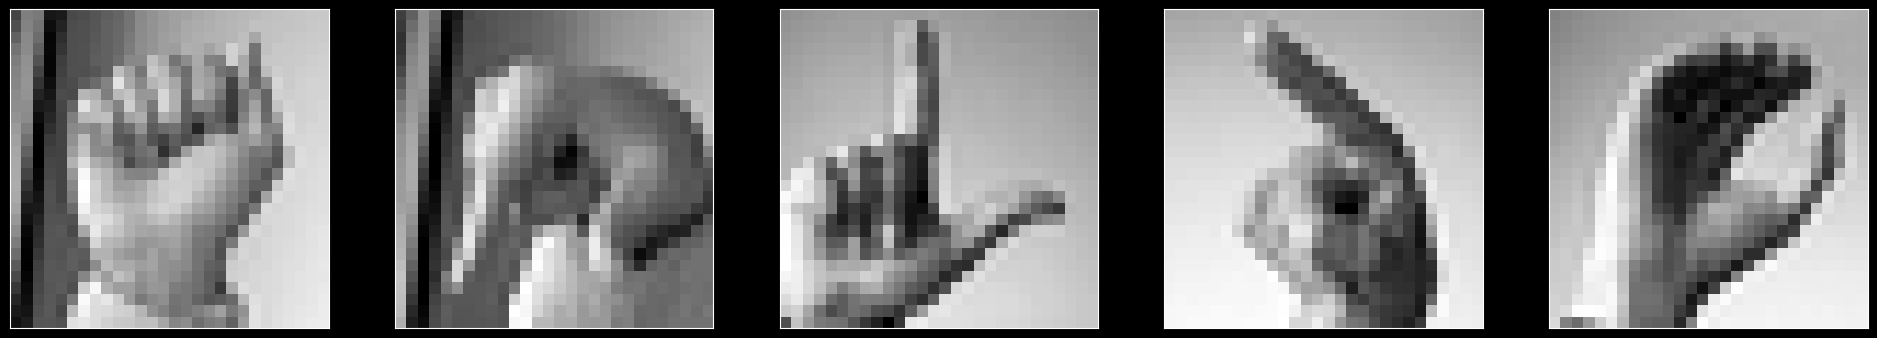

In [19]:
plt.figure(figsize=(24,24))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
plt.show()

For the cells below, it is a pre-check before model training to assure that the training data matches interms of structure.

In [19]:
x_train.shape

(19218, 28, 28, 1)

In [20]:
x_train[0].shape

(28, 28, 1)

In [21]:
y_train.shape

(19218, 24)

In [22]:
y_train[5:]

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
y_test[5:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# **Train the model**

In [20]:
# Train the model
history=model.fit(x_train,y_train, validation_data = (x_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
151/151 [==============================] - 21s 121ms/step - loss: 2.8375 - accuracy: 0.1556 - val_loss: 2.1320 - val_accuracy: 0.3282
Epoch 2/10
151/151 [==============================] - 20s 134ms/step - loss: 1.6875 - accuracy: 0.4553 - val_loss: 1.3553 - val_accuracy: 0.5512
Epoch 3/10
151/151 [==============================] - 18s 117ms/step - loss: 1.1857 - accuracy: 0.6044 - val_loss: 1.1079 - val_accuracy: 0.6230
Epoch 4/10
151/151 [==============================] - 21s 136ms/step - loss: 0.9317 - accuracy: 0.6823 - val_loss: 0.8997 - val_accuracy: 0.6795
Epoch 5/10
151/151 [==============================] - 21s 142ms/step - loss: 0.7701 - accuracy: 0.7394 - val_loss: 0.7021 - val_accuracy: 0.7633
Epoch 6/10
151/151 [==============================] - 20s 131ms/step - loss: 0.6356 - accuracy: 0.7864 - val_loss: 0.5878 - val_accuracy: 0.8060
Epoch 7/10
151/151 [==============================] - 17s 115ms/step - loss: 0.5257 - accuracy: 0.8280 - val_loss: 0.5588 - val_ac

In [28]:
# Save the trained model
model.save('sign_language_model.h5')
print("Model saved")

Model saved


**Evaluate accuracy**
Next, compare how the model performs on the y_test within the same dataset

In [21]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

258/258 - 2s - loss: 0.3004 - accuracy: 0.9144 - 2s/epoch - 6ms/step

Test accuracy: 0.9144105911254883


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap of 0.0057 between training accuracy and test accuracy represents overfitting. The overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data.

# **Loss vs. Epoch**
Loss vs. epoch graphs are a neat way of visualizing our progress while training a neural network. To make such a graph, we plot the loss against the epochs.

The consecutive points on the line correspond to the values recorded in successive epochs.

These graphs can detect overfitting and underfitting and inform us about early stopping.

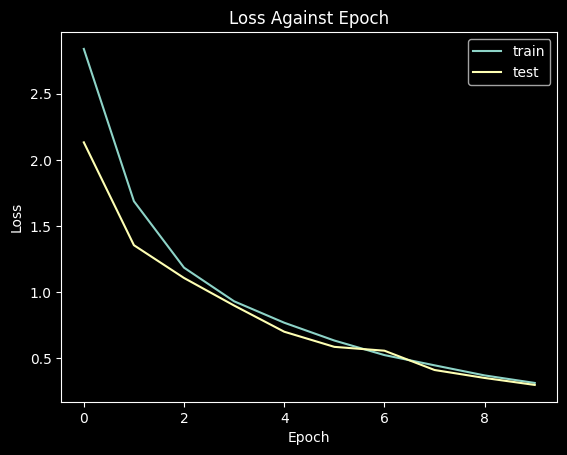

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Against Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.show()

In [23]:
#Defining the label column from the testing dataset
test_labels = df_test['label'].values

In [24]:
# Since all images are in a row of 785 values,
# label column has to be dropped and reshape 784 pixel columns to 28 x 28 shape
test_pixels = df_test.drop('label', axis = 1, inplace = True)
test_pixels = df_test.values
test_pixels = np.array([np.reshape(i,(28,28)) for i in test_pixels])
test_pixels = np.array([i.flatten() for i in test_pixels])

In [25]:

# Since we have more than 2 labels, hot 1 encoding is implemented
from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
test_labels = label_binrizer.fit_transform(test_labels)
test_pixels = test_pixels.reshape(test_pixels.shape[0],28,28,1)


The line Y_pred = model.predict(test_pixels) is using the trained neural network model (model) to make predictions on a set of test data (test_pixels).

In [26]:
Y_pred = model.predict(test_pixels)


225/225 [==============================] - 2s 7ms/step


Accuracy score for the testing predictions

In [27]:
accuracy_score(test_labels, Y_pred.round())

0.7064974902398216

It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents overfitting. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data.

In [29]:
# A function that matches the labels to letters
def getLetter(result):
    classLabels = { 0:'A',
                    1:'B',
                    2:'C',
                    3:'D',
                    4:'E',
                    5:'F',
                    6:'G',
                    7:'H',
                    8:'I',
                    9:'K',
                    10:'L',
                    11:'M',
                    12:'N',
                    13:'O',
                    14:'P',
                    15:'Q',
                    16:'R',
                    17:'S',
                    18:'T',
                    19:'U',
                    20:'V',
                    21:'W',
                    22:'X',
                    23:'Y',}
    try :
         res = int(result)
         return classLabels[res]
    except:
        return 'hand'


This code utilizes the OpenCV library to capture video from a camera (cv2.VideoCapture(0)), process each frame, define a region of interest (ROI), and then use a trained neural network model (model) to make predictions on the content of that ROI

In [31]:
import cv2
cap = cv2.VideoCapture(0)

while True:
  ret, frame = cap.read()
  #It reads a frame from the video capture (cap.read()), and then flips the frame horizontally using cv2.flip().
  frame = cv2.flip(frame, 1)

  #Area of interest definition
  roi = frame[100:400, 320:620]
  #It displays the region of interest in a window titled 'roi'.
  cv2.imshow('roi',roi)
  roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
  roi = cv2.resize(roi, (28,28), interpolation = cv2.INTER_AREA)

  #It displays the preprocessed ROI in a window titled 'roi scaled and gray'.
  cv2.imshow('roi sacled and gray', roi)
  copy = frame.copy()
  cv2.rectangle(copy, (320, 100),(620, 400),(255,0,0),5)
  #It reshapes the preprocessed ROI to match the expected input shape of the neural network model.
  # It then uses the model to make a prediction on the reshaped ROI.
  roi = roi.reshape(1,28,28,1)
  result = str(model.predict(roi,1,verbose = 0)[0])
  #It adds text to the frame displaying the prediction
  #.getLetter(result) function is assumed to provide the corresponding letter for the prediction.
  cv2.putText(copy, getLetter(result), (300,100), cv2.FONT_HERSHEY_COMPLEX, 2,(0, 255,0),2)
  #It displays the updated frame with the rectangle and prediction text in a window titled 'frame
  cv2.imshow('frame', copy)
  #It waits for the Enter key to be pressed (ASCII code 13) and breaks out of the loop if detected.
  if cv2.waitKey(1) == 13: #13 is the enter key
    break
cap.release()
cv2.destroyAllwindows()
#The code below releases the video capture resources and closes all OpenCV windows.
#close the webcam by stopping the cell run

TypeError: 'NoneType' object is not subscriptable